# **INSTALL DEPENDENCIES AND DRIVE CONNECTION** 📚

In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
os.chdir('/content/drive/MyDrive/Neural_Style_Transfer/')
!ls

images	losses	Neural_Style_Transfer.ipynb  outputs  results


In [4]:
# IDENTIFY CORRECT DEVICE
if torch.backends.mps.is_available():
    dev = "mps"
elif torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda


# **PREPROCESSING** ⚙

In [5]:
def load_picture(picture_path, transform=None, max_size=None, shape=None):
   # image --> pytorch tensor
    pic = Image.open(picture_path)

    if max_size:
        scale = max_size / max(pic.size)
        size = np.array(pic.size) * scale
        pic = pic.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        pic = pic.resize(shape, Image.LANCZOS)

    if transform:
        pic = transform(pic).unsqueeze(0)

    return pic.to(device)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)),
])

#**FEATURE EXTRACTOR** ⛏

In [60]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features
    def forward(self, x):
        # Specify layer indices for feature extraction
        layer_indices = [0, 5, 10, 19, 28]
        features = []
        for idx, (name, layer) in enumerate(self.vgg._modules.items()):
            x = layer(x)
            if idx in layer_indices:
                features.append(x)
        return features

# **CONFIGURATION** ☣

In [62]:
lr = 0.003 # default
painting_weight = 100 # default 120
total_steps = 3000 #default 100
print_step = 50 # default total_steps // 10
save_step = 10 # default total_steps // 5
max_size = 400

base = load_picture("./images/colosseo.jpg", transform=transform, max_size = max_size)
painting = load_picture("./images/picasso.jpg", transform=transform, shape=[base.size(2), base.size(3)])

goal = base.clone().requires_grad_(True)

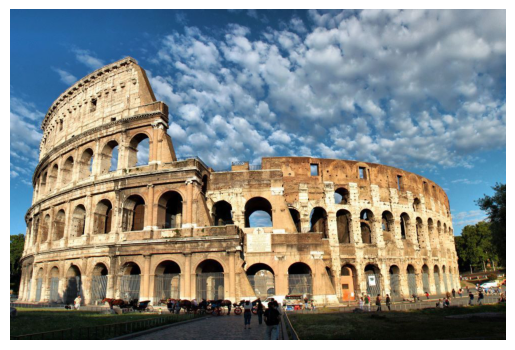

In [63]:
base_orig = mpimg.imread('./images/colosseo.jpg')

# Display the image using Matplotlib
plt.imshow(base_orig)
plt.axis('off')
plt.show()

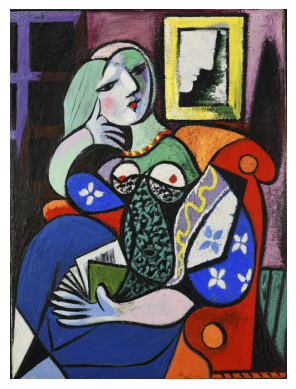

In [64]:
painting_orig = mpimg.imread('./images/picasso.jpg')

# Display the image using Matplotlib
plt.imshow(painting_orig)
plt.axis('off')
plt.show()

In [65]:
optimizer = torch.optim.Adam([goal], lr=lr, betas=[0.5, 0.999])
net = VGGNet().to(device).eval()

# **RUN** 🏃

In [66]:
base_losses = []
painting_losses = []
losses = []

for step in range(total_steps):
    goal_features = net(goal)
    base_features = net(base)
    painting_features = net(painting)

    painting_loss = 0
    base_loss = 0

    for goal_f, base_f, painting_f in zip(
        goal_features, base_features, painting_features
    ):
        base_loss += torch.mean((goal_f - base_f) ** 2)

        _, c, h, w = base_f.size()
        goal_f = goal_f.reshape(c, -1)
        painting_f = painting_f.reshape(c, -1)

        goal_gram = torch.mm(goal_f, goal_f.t())
        painting_gram = torch.mm(painting_f, painting_f.t())

        painting_loss += torch.mean((goal_gram - painting_gram) ** 2) / (c * h * w)

    loss = base_loss + painting_weight * painting_loss

    base_losses.append(base_loss.item())
    painting_losses.append(painting_loss.item())
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    if (step+1) % print_step == 0:
            print ('Step [{}/{}], Base Loss: {:.4f}, Painting Loss: {:.4f}' .format(step+1, total_steps, base_loss.item(), painting_loss.item()))

    if (step+1) % save_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            pic = goal.clone().squeeze()
            pic = denorm(pic).clamp_(0, 1)
            save_folder = f"./outputs/output_{step + 1}.png"

            torchvision.utils.save_image(pic, save_folder)



Step [50/3000], Base Loss: 23.5877, Painting Loss: 141.0759
Step [100/3000], Base Loss: 34.1183, Painting Loss: 85.5163
Step [150/3000], Base Loss: 40.2134, Painting Loss: 62.2817
Step [200/3000], Base Loss: 44.2963, Painting Loss: 49.3776
Step [250/3000], Base Loss: 47.1972, Painting Loss: 41.2530
Step [300/3000], Base Loss: 49.4196, Painting Loss: 35.6618
Step [350/3000], Base Loss: 51.2390, Painting Loss: 31.5423
Step [400/3000], Base Loss: 52.7732, Painting Loss: 28.3760
Step [450/3000], Base Loss: 54.0496, Painting Loss: 25.8678
Step [500/3000], Base Loss: 55.1382, Painting Loss: 23.8080
Step [550/3000], Base Loss: 56.1062, Painting Loss: 22.0872
Step [600/3000], Base Loss: 56.9694, Painting Loss: 20.6265
Step [650/3000], Base Loss: 57.7508, Painting Loss: 19.3727
Step [700/3000], Base Loss: 58.4703, Painting Loss: 18.2751
Step [750/3000], Base Loss: 59.1395, Painting Loss: 17.3035
Step [800/3000], Base Loss: 59.7556, Painting Loss: 16.4430
Step [850/3000], Base Loss: 60.3462, Pai

# **SHOW RESULTS** 🤩 🙂

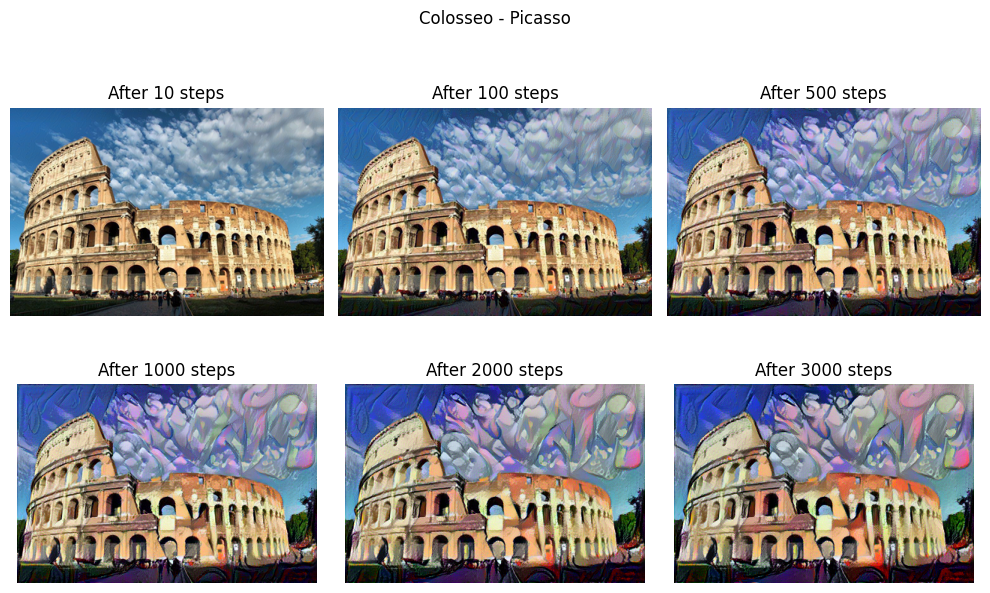

In [67]:
pic1 = mpimg.imread('./outputs/output_10.png')
pic2 = mpimg.imread('./outputs/output_100.png')
pic3 = mpimg.imread('./outputs/output_500.png')
pic4 = mpimg.imread('./outputs/output_1000.png')
pic5 = mpimg.imread('./outputs/output_2000.png')
pic6 = mpimg.imread('./outputs/output_3000.png')


# Load the images
img1 = np.array(pic1)
img2 = np.array(pic2)
img3 = np.array(pic3)
img4 = np.array(pic4)
img5 = np.array(pic5)
img6 = np.array(pic6)

# Create a 2 x 3 grid of subplots
fig, ax = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]})

# Plot the images in the grid
ax[0, 0].imshow(img1)
ax[0, 0].set_title('After 10 steps')
ax[0, 1].imshow(img2)
ax[0, 1].set_title('After 100 steps')
ax[0, 2].imshow(img3)
ax[0, 2].set_title('After 500 steps')
ax[1, 0].imshow(img4)
ax[1, 0].set_title('After 1000 steps')
ax[1, 1].imshow(img5)
ax[1, 1].set_title('After 2000 steps')
ax[1, 2].imshow(img6)
ax[1, 2].set_title('After 3000 steps')

# Hide the axes for a cleaner layout
for i in range(2):
    for j in range(3):
        ax[i, j].axis('off')

plt.tight_layout()

plt.suptitle('Colosseo - Picasso')

# Save the plot to a PNG file
plt.savefig('./results/colosseo-picasso.png')

plt.show()

# **LOSS PLOTS** 🔎

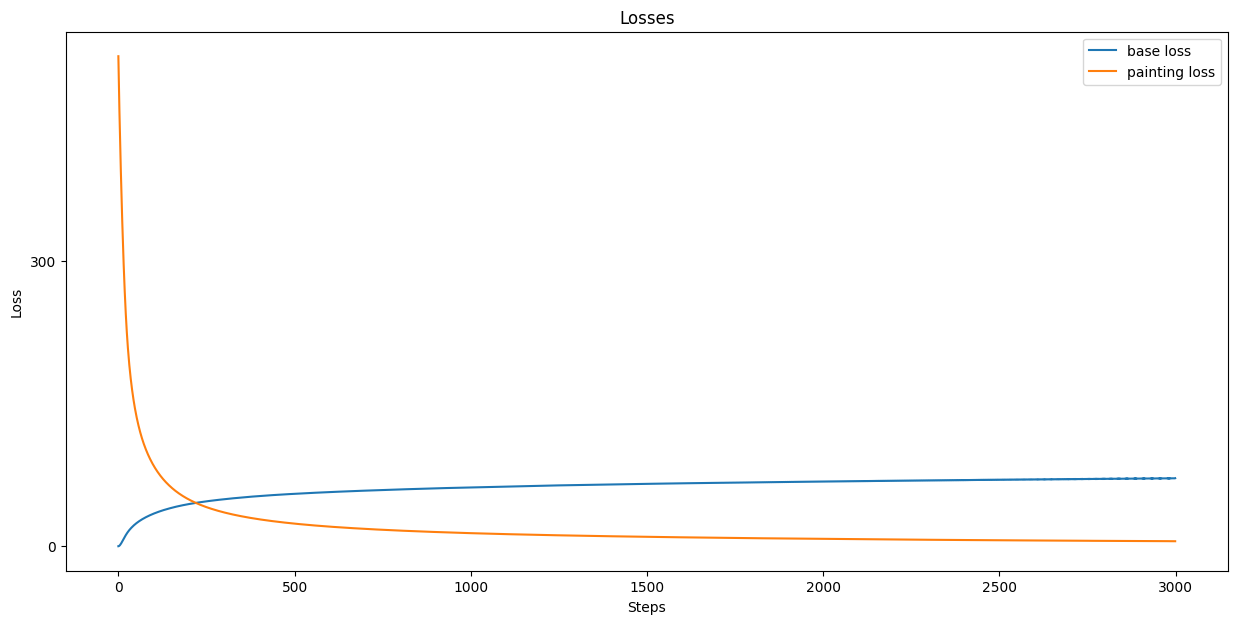

In [68]:
save_folder = './losses/'
plot_name = f'base_and_painting_losses.png'
file_path = os.path.join(save_folder, plot_name)

#fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(, 15))
steps = total_steps

plt.figure(figsize=(15, 7))

plt.plot(np.arange(steps), base_losses, label='base loss')
plt.plot(np.arange(steps), painting_losses, label='painting loss')
plt.legend()

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yticks(np.arange(0, max(painting_losses), 300))

plt.title('Losses')
plt.savefig(file_path, dpi=500)
plt.show()

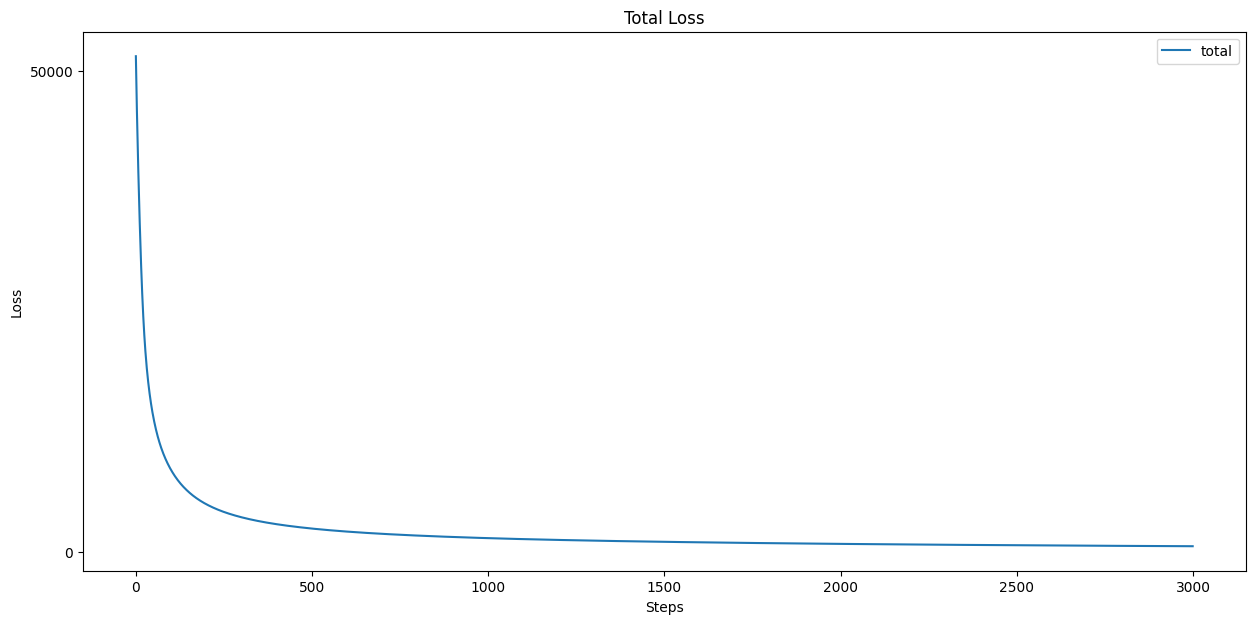

In [69]:
save_folder = './losses/'
plot_name = f'total_loss.png'
file_path = os.path.join(save_folder, plot_name)

plt.figure(figsize=(15, 7))
#plt.plot(np.arange(steps), total_loss_scaled, label='total')
plt.plot(np.arange(steps), losses, label='total')
plt.legend()

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yticks(np.arange(0, max(losses), 50000))

plt.title('Total Loss')
plt.savefig(file_path, dpi=500)

plt.show()